In [33]:
import yfinance as yf
from datetime import datetime, timedelta
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Configure Tesla data download
ticker = 'TSLA'
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=729)).strftime('%Y-%m-%d')  # Max 730 days back


In [ ]:
try:
    print(f"⏳ Downloading {ticker} hourly data ({start_date} to {end_date})...")
    df_original = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        interval='60m',
        progress=False
    )

    if not df_original.empty:
        # 1. Remove timezone from index
        df_original.index = df_original.index.tz_localize(None)

        # 2. Create complete save path
        save_dir = '/content/drive/MyDrive/Data_analysis/Final_project_data_analysis/final_data/'
        os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
        save_path = os.path.join(save_dir, "TSLA_hourly_raw.xlsx")

        # 3. Save to Excel
        df_original.to_excel(save_path)

        print(f"✅ Successfully saved to:\n{save_path}")
        print(f"📊 Rows saved: {len(df_original)}")
        print(f"📅 Date range: {df_original.index[0]} to {df_original.index[-1]}")

        # 4. Optional: Download to local machine
        from google.colab import files
        files.download(save_path)
    else:
        print("❌ No data returned. Market may have been closed during this period.")

except Exception as e:
    print(f"❌ Error: {str(e)}")
    print("ℹ️ Possible solutions:")
    print("- Try a smaller date range (max 730 days)")
    print("- Verify ticker symbol is correct")
    print("- Check your internet connection")
    print("- Try again during market hours (9:30 AM - 4 PM ET)")

⏳ Downloading TSLA hourly data (2023-04-04 to 2025-04-02)...
✅ Successfully saved to:
/content/drive/MyDrive/Data_analysis/Final_project_data_analysis/final_data/TSLA_hourly_raw.xlsx
📊 Rows saved: 3480
📅 Date range: 2023-04-04 13:30:00 to 2025-04-01 19:30:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = df_original.copy()

In [ ]:
# Remove the Ticker level (if the DataFrame has a MultiIndex in columns)
df.columns = df.columns.droplevel('Ticker')

# Verify the updated structure
print(df.head())
print(df.columns)


Price                     Close        High         Low        Open    Volume
Datetime                                                                     
2023-04-04 13:30:00  193.720001  198.744598  192.800003  197.156693  41813950
2023-04-04 14:30:00  191.228302  194.059998  190.590393  193.729996  21852935
2023-04-04 15:30:00  191.639297  192.289993  190.690002  191.199997  15602779
2023-04-04 16:30:00  192.160004  192.490005  191.199997  191.639999  12196915
2023-04-04 17:30:00  191.259903  192.720001  191.199997  192.130096  11485289
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [ ]:
# Function to fill NaNs with the average of the row above and below
def fill_nan_with_neighbors(df):
    for col in df.columns:
        df[col] = df[col].mask(df[col].isna(), (df[col].shift(1) + df[col].shift(-1)) / 2)
    return df

# Apply to the dataset before analysis
df = fill_nan_with_neighbors(df)

In [ ]:
# Calculate Simple Moving Averages (SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [ ]:
# Calculate Exponential Moving Averages (EMA)
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

In [ ]:
# Calculate RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
# Calculate Average True Range (ATR)
true_range = pd.DataFrame()
# Calculate True Range
true_range["high_low"] = df['High'] - df['Low']
true_range["high_close"] = (df['High'] - df['Close'].shift()).abs()
true_range["low_close"] = (df['Low'] - df['Close'].shift()).abs()
# Calculate ATR
df['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

In [ ]:
# Calculate MACD (12-day EMA - 26-day EMA) and Signal Line (9-day EMA of MACD)
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
# Calculate Bollinger Bands (20-day SMA ± 2 std dev)
# Calculate the rolling mean (middle Bollinger Band)
df['Bollinger_Mid'] = df['Close'].rolling(window=20).mean()

# Ensure the rolling standard deviation is treated as a Series
rolling_std = df['Close'].rolling(window=20).std().squeeze()

# Calculate the upper and lower Bollinger Bands with proper alignment
df['Bollinger_Upper'] = df['Bollinger_Mid'] + (rolling_std * 2)
df['Bollinger_Lower'] = df['Bollinger_Mid'] - (rolling_std * 2)

In [ ]:
# Calculate VWAP (Cumulative Volume-Weighted Average Price)
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

# Calculate Candle Width (Close - Open)
df['Candle_Width'] = df['Close'] - df['Open']

# Calculate Daily % Change
df['% Change'] = df['Close'].pct_change() * 100

# Calculate On-Balance Volume (OBV)
df['OBV'] = (df['Volume'] * ((df['Close'] - df['Close'].shift()) >= 0).astype(int) * 2 - 1).cumsum()

# Calculate Cumulative Returns
df['Cumulative_Return'] = (1 + df['% Change'] / 100).cumprod() - 1

# Calculate Sharpe Ratio (assuming a 1% risk-free rate)
rf_rate = 0.01  # Example: 1% risk-free rate
df['Daily_Return'] = df['% Change'] / 100
excess_return = df['Daily_Return'] - rf_rate / 252
sharpe_ratio = excess_return.mean() / excess_return.std() * (252 ** 0.5)

In [ ]:
# Select relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume',
         'SMA_5', 'SMA_20', 'SMA_50', 'SMA_200',
         'EMA_5', 'EMA_20', 'EMA_50', 'EMA_200',
         'RSI', 'ATR', 'MACD', 'MACD_Signal',
         'Bollinger_Upper', 'Bollinger_Mid', 'Bollinger_Lower',
         'VWAP', 'Candle_Width', '% Change', 'OBV', 'Cumulative_Return']]

In [ ]:
df.head()

Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,SMA_50,SMA_200,EMA_5,...,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Mid,Bollinger_Lower,VWAP,Candle_Width,% Change,OBV,Cumulative_Return
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-04 13:30:00,197.156693,198.744598,192.800003,193.720001,41813950,NaN,NaN,NaN,NaN,193.720001,...,0.000000,0.000000,NaN,NaN,NaN,193.720001,-3.436691,NaN,-1,NaN
2023-04-04 14:30:00,193.729996,194.059998,190.590393,191.228302,21852935,NaN,NaN,NaN,NaN,192.889435,...,-0.198768,-0.039754,NaN,NaN,NaN,192.864754,-2.501694,-1.286237,-2,-0.012862
2023-04-04 15:30:00,191.199997,192.289993,190.690002,191.639297,15602779,NaN,NaN,NaN,NaN,192.472722,...,-0.319447,-0.095692,NaN,NaN,NaN,192.623545,0.439301,0.214924,31205555,-0.010741
2023-04-04 16:30:00,191.639999,192.490005,191.199997,192.160004,12196915,NaN,NaN,NaN,NaN,192.368483,...,-0.368818,-0.150317,NaN,NaN,NaN,192.561733,0.520004,0.271712,55599384,-0.008053
2023-04-04 17:30:00,192.130096,192.720001,191.199997,191.259903,11485289,192.001501,NaN,NaN,NaN,191.998956,...,-0.475098,-0.215273,NaN,NaN,NaN,192.416501,-0.870193,-0.468412,55599383,-0.012699


In [ ]:
df.to_excel(os.path.join(save_dir, "TSLA_hourly_with_features.xlsx"), sheet_name='Tesla Stock Data')

In [31]:
# Drop the first 200 rows and reset the index
df = df.iloc[200:]

In [32]:
# Save to Excel file
df.to_excel(os.path.join(save_dir, "TSLA_hourly_with_processed_without_NAN.xlsx"), sheet_name='Tesla Stock Data')


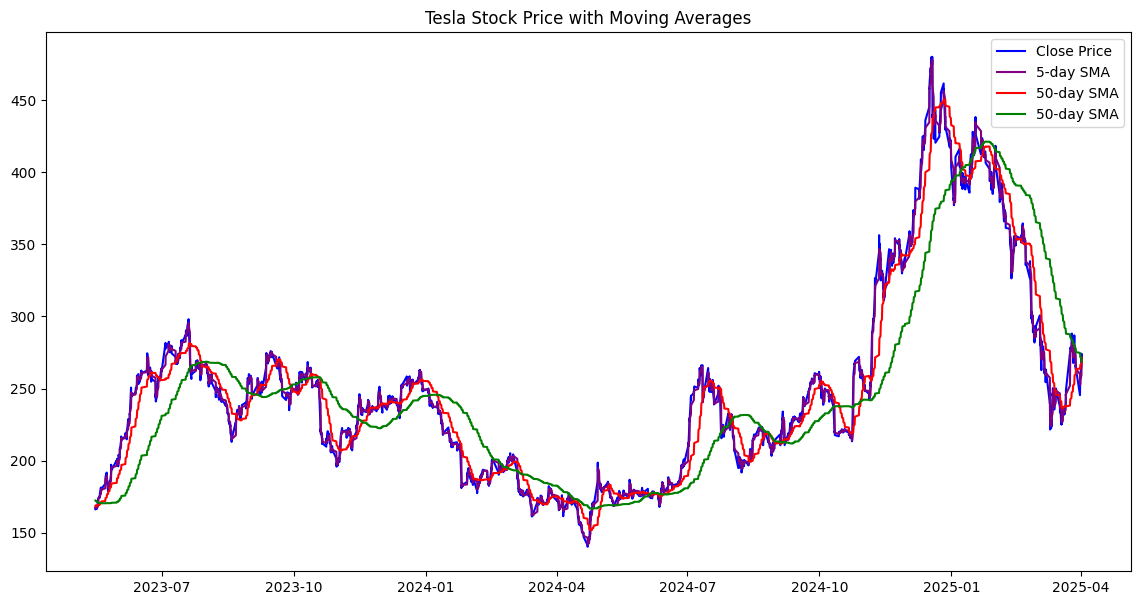

Sharpe Ratio: 0.17050442522581377


In [34]:
# Plot Close Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['SMA_5'], label='5-day SMA', color='purple')
plt.plot(df['SMA_50'], label='50-day SMA', color='red')
plt.plot(df['SMA_200'], label='50-day SMA', color='green')

plt.title('Tesla Stock Price with Moving Averages')
plt.legend(loc='best')
plt.show()

# Print Sharpe Ratio
print(f'Sharpe Ratio: {sharpe_ratio}')


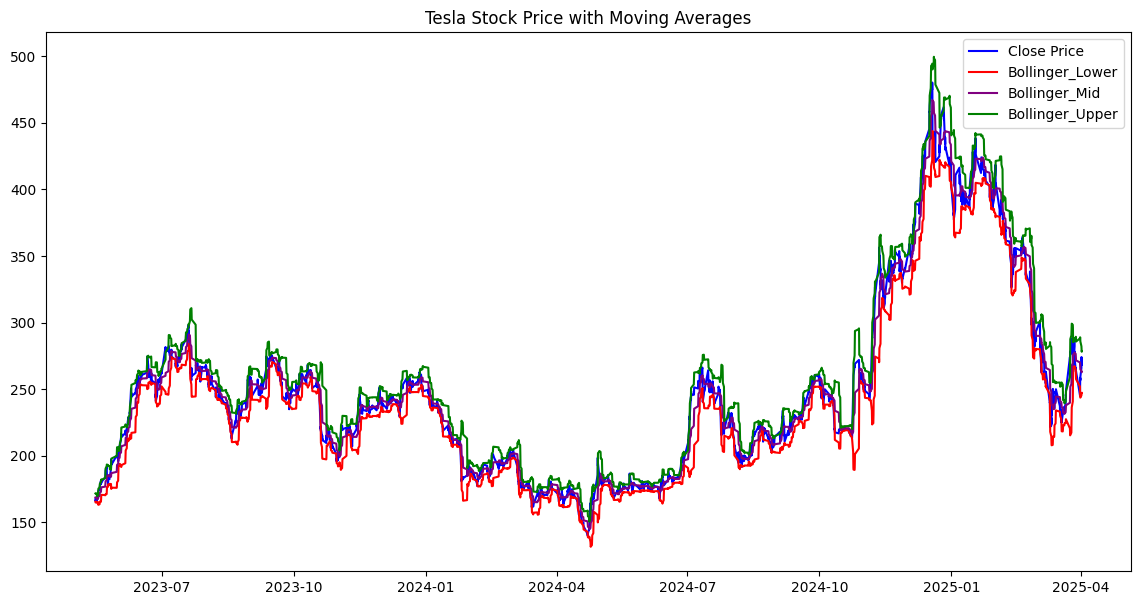

In [35]:
# Plot Close Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')

plt.plot(df['Bollinger_Lower'], label='Bollinger_Lower', color='red')
plt.plot(df["Bollinger_Mid"], label='Bollinger_Mid', color='purple')
plt.plot(df["Bollinger_Upper"], label='Bollinger_Upper', color='green')

plt.title('Tesla Stock Price with Moving Averages')
plt.legend(loc='best')
plt.show()

In [38]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00


In [36]:
print(df.dtypes)  # Check column data types
print(df['Open'].apply(type).unique())  # Check data types in "Open" column


Price
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
SMA_5                float64
SMA_20               float64
SMA_50               float64
SMA_200              float64
EMA_5                float64
EMA_20               float64
EMA_50               float64
EMA_200              float64
RSI                  float64
ATR                  float64
MACD                 float64
MACD_Signal          float64
Bollinger_Upper      float64
Bollinger_Mid        float64
Bollinger_Lower      float64
VWAP                 float64
Candle_Width         float64
% Change             float64
OBV                    int64
Cumulative_Return    float64
dtype: object
[<class 'float'>]


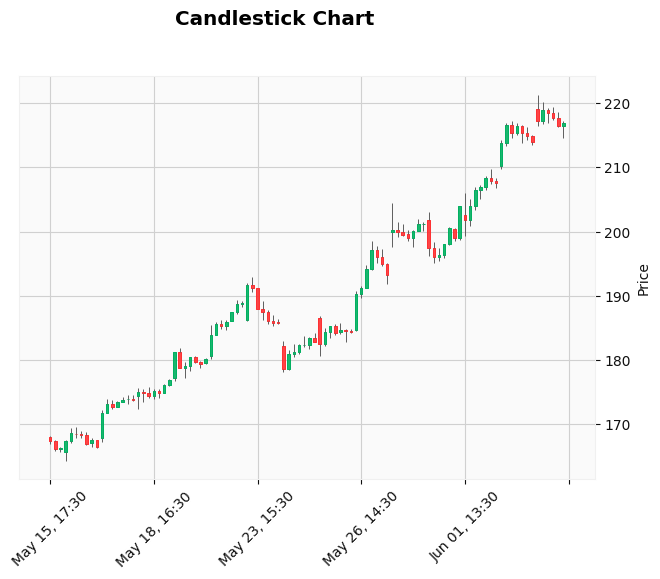

In [39]:
import mplfinance as mpf

# Plotting the candlestick chart
mpf.plot(df.iloc[0:100, 0:5], type='candle', title='Candlestick Chart', style='yahoo')

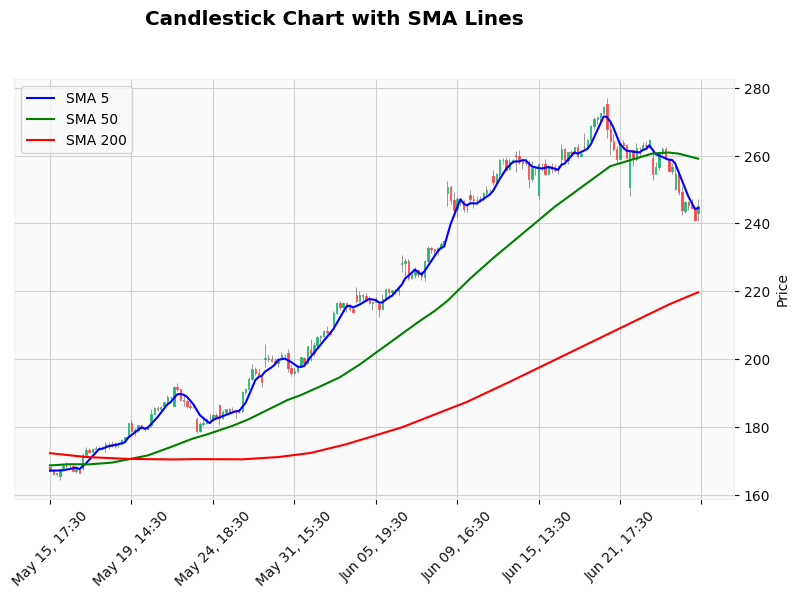

In [40]:
add_sma_5 = mpf.make_addplot(df.iloc[0:200]['SMA_5'], color='blue', width=1.5, label='SMA 5')
add_sma_50 = mpf.make_addplot(df.iloc[0:200]['SMA_50'], color='green', width=1.5, label='SMA 50')
add_sma_200 = mpf.make_addplot(df.iloc[0:200]['SMA_200'], color='red', width=1.5, label='SMA 200')

# Plot the candlestick chart with the SMAs
mpf.plot(df.iloc[0:200, 0:5], type='candle', addplot=[add_sma_5, add_sma_50, add_sma_200],
         title='Candlestick Chart with SMA Lines', style='yahoo', figsize=(10, 6))